<a href="https://colab.research.google.com/github/SadafShafi/CoolTensorflowScripts/blob/main/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# train set / data 
x_train = x_train.astype('float32') / 255
# train set / target 
# y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)

# validation set / data 
x_test = x_test.astype('float32') / 255
# validation set / target 
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape) 

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128*2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128*4, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(128*2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(128*4, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(128*2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10))

func_model = model

In [4]:
func_model.compile(
          loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics   =  ['accuracy'],
          # tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam(0.0005)
          )
# fit 
func_model.fit(x_train, y_train,
               validation_split = 0.2,
              #  batch_size=128, 
               epochs=10, )

Epoch 1/10
1250/1250 [==============================] - 78s 36ms/step - loss: 2.3602 - accuracy: 0.2165 - val_loss: 1.7969 - val_accuracy: 0.3301
Epoch 2/10
1250/1250 [==============================] - 44s 35ms/step - loss: 1.7791 - accuracy: 0.3453 - val_loss: 1.5449 - val_accuracy: 0.4304
Epoch 3/10
1250/1250 [==============================] - 44s 36ms/step - loss: 1.5506 - accuracy: 0.4335 - val_loss: 1.4077 - val_accuracy: 0.4800
Epoch 4/10
1250/1250 [==============================] - 44s 36ms/step - loss: 1.3905 - accuracy: 0.4958 - val_loss: 1.1876 - val_accuracy: 0.5604
Epoch 5/10
1250/1250 [==============================] - 45s 36ms/step - loss: 1.2474 - accuracy: 0.5605 - val_loss: 1.0235 - val_accuracy: 0.6339
Epoch 6/10
1250/1250 [==============================] - 43s 34ms/step - loss: 1.1169 - accuracy: 0.6105 - val_loss: 0.9668 - val_accuracy: 0.6576
Epoch 7/10
1250/1250 [==============================] - 44s 35ms/step - loss: 1.0132 - accuracy: 0.6538 - val_loss: 0.8469 -

**GradCam Algorithm**

In [5]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [131]:
# Generate a random image to be tested
from random import randint
from PIL import Image
idx = randint(0,len(x_test))
im = Image.fromarray((x_test[idx] * 255).astype(np.uint8))
im.save("your_file.jpg")

In [132]:
impath = "/content/your_file.jpg"
image = cv2.imread(impath)
x = np.expand_dims(image, axis=0)

In [133]:
labels = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
# image = x_test[0]
image = cv2.resize(image, (32, 32))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = func_model.predict(image) 
i = np.argmax(preds[0])
i

8

In [134]:
# impath = '/content/dog.jpg'
image = cv2.imread(impath)
# image = x_test[0]
image = cv2.resize(image, (32, 32))
image = np.expand_dims(image,axis=0)
image.shape

(1, 32, 32, 3)

In [135]:
icam = GradCAM(func_model, i, None) 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (32, 32))

image = cv2.imread(impath)
# image = x_test[0]

# print(image.shape,x_test[0].shape)
image = cv2.resize(image, (32, 32))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(32, 32) (32, 32, 3)


ship


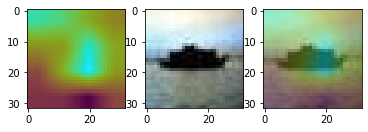

In [136]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3)
print(labels[i])
ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

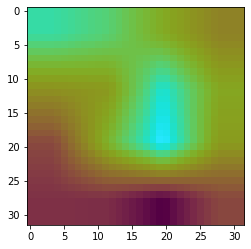

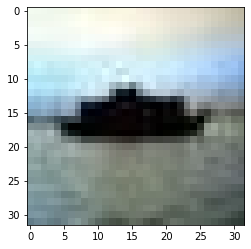

ship


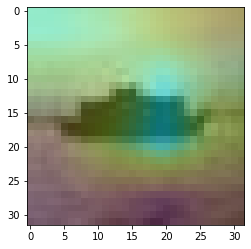

In [137]:
plt.imshow(heatmap)
plt.show()
plt.imshow(image)
plt.show()
print(labels[i])
plt.imshow(output)
plt.show()